In [1]:
'''
TEMAT 3. Cyfromania
a. Rozpoznawanie zestawu ręcznie pisanych cyfr
b. Ciąg n cyfr opartych o MNIST
c. typ zadania: klasyfikacja sekwencji znaków z możliwym wykorzystaniem
rekurencyjnych sieci neuronowych
d. wersja podstawowa: stała ilość cyfr
e. wersja zaawansowana: zmienna ilość cyfr na obrazie
f. ciekawe rozszerzenie: wykonywanie obliczeń pisanych ręcznie na kartce

'''

'\nTEMAT 3. Cyfromania\na. Rozpoznawanie zestawu ręcznie pisanych cyfr\nb. Ciąg n cyfr opartych o MNIST\nc. typ zadania: klasyfikacja sekwencji znaków z możliwym wykorzystaniem\nrekurencyjnych sieci neuronowych\nd. wersja podstawowa: stała ilość cyfr\ne. wersja zaawansowana: zmienna ilość cyfr na obrazie\nf. ciekawe rozszerzenie: wykonywanie obliczeń pisanych ręcznie na kartce\n\n'

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
import cv2
import datetime
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [2]:
# tylko dla tych co mają zainstalowaną paczkę jupyterthemes
# kto nie ma to niech zakomentuje, ponieważ będzie wywalać błąd
#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [3]:
# load dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

image = X_train[sample]
num = len(X_train)

images_X = X_train[:num]
images_Y = Y_train[:num]

NameError: name 'sample' is not defined

In [5]:
from random import randint

for i in range(0,4):
    index1 = randint(0,num-1)
    index2 = randint(0,num-1)
    index3 = randint(0,num-1)
    index4 = randint(0,num-1)
    
    img_X = np.concatenate((images_X[index1],images_X[index2],images_X[index3],images_X[index4]), axis = 1)
    img_Y = (images_Y[index1], images_Y[index2], images_Y[index3], images_Y[index4] )
   
    print(img_Y)
    plt.imshow(img_X)
    
    plt.show()

NameError: name 'num' is not defined

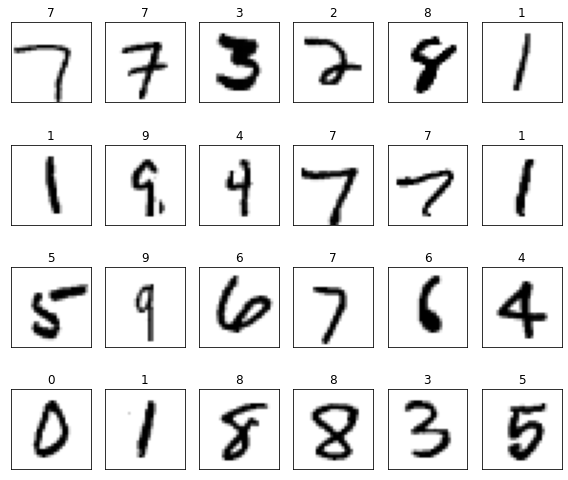

In [6]:
index = np.random.choice(np.arange(len(X_train)),24,replace=False)
fig,axes = plt.subplots(nrows=4,ncols=6,figsize=(8,8))
for item in zip(axes.ravel(),X_train[index],Y_train[index]):
    axes,image,target = item
    axes.imshow(image,cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(target)
    plt.tight_layout()

In [7]:
print(f"X train shape - {X_train.shape}\nX test shape - {X_test.shape}")

X train shape - (60000, 28, 28)
X test shape - (10000, 28, 28)


In [8]:
# reshape danych w związku z tym, że Keras potrzebuje kształtu w postaci (Szerokość, wysokość, kanały) gdzie "kanały" to wartość 0-255 określającą odcień szarości
X_train = X_train.reshape((60000,28,28,1))
X_test = X_test.reshape((10000,28,28,1))


In [9]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [10]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# CNN

In [11]:
from tensorflow.keras.models import Sequential

cnn = Sequential()

In [12]:
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D

# warstwa konwulcji
# 64 filtry, rozmiar jądra 3x3, aktywacja przez ReLU, inputem będą daane o kształcie 28,28,1
cnn.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu',input_shape=(28,28,1)))

# warstwa łącząca
# rozmiar pool'a 2x2
cnn.add(MaxPooling2D(pool_size=(2,2)))

# kolejna warstwa konwulcji
# 128 filtrów, rozmiar jądra 3x3, aktywacja przez relu
cnn.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))

# kolejna warstwa łącząca
# rozmiar pool'a dalej 2x2
cnn.add(MaxPooling2D(pool_size=(2,2)))

# warstwa spłaszczająca
cnn.add(Flatten())

# warstwa gęsta
# 128 neuronów, funkcja aktywacji ReLU
cnn.add(Dense(units=128,activation='relu'))

# warstwa wyjściowa produkująca wynik (klasyfikacje 0-9), 10 neuronów bo 10 możliwych wyników liczb, funkcja aktywacji softmax (zwraca wartość o największej wartości probabilistycznej)
cnn.add(Dense(units=10,activation='softmax'))



In [13]:
# Podsumowanie modelu wraz z kształtem inputów na warstwie i parametrów
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               409728    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

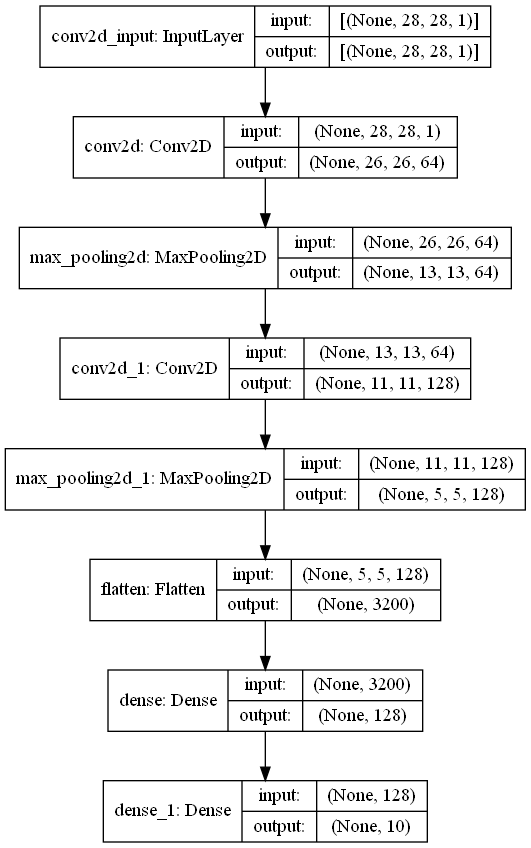

In [14]:
# Na zdjęciu widać zmianę wymiarowości począwszy od 28x28x1 aż do docelowych 10 outputów liczbowych
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(cnn,to_file="CNN.png",show_shapes=True,show_layer_names=True)
Image(filename="CNN.png")

In [17]:
# kompilacja modelu
# używamy optimizera adam, funkcję straty crossentropy która jest idealna dla multiklasyfikacji (jak u nas 10 możliwych wyników) i metryki accuracy, która określa % trafnych dopasowań w naszym modelu klasyfikacyjnym
cnn.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['accuracy'])

In [18]:
# fit modelu naszymi danymi
# wybieramy 5/10 epok jako optymalną ilość kompletnych przetworzeń danych treningowych przez model
# wybieramy batch_size jako 32/64 (ilość próbek w batchu), czyli porcji przetwarzanej jednorazowo przez model w ramach 1 epoki. Po przetworzeniu każdego batchu, sieć aktualizuje parametry.
# wybieramy validation_split na 0.1 co oznacza, że z każdej epoki bierzemy 10% liczb w celu walidacji i wyświetleniu wyników walidacyjnych jak accuracy i loss

cnn.fit(X_train,Y_train,epochs=5,batch_size=64,validation_split=0.1)

# Końcowo lądujemy z ilością 1688 danych per epokę (60.000 danych w zbiorze treningowym / batch_size - 10% z tego dzielenia ze względu na użycie splitu walidacyjnego 0.1)
# Wyświetlają nam się dane jak loss i accuracy oszacowane przez model w każdej epoce i wyniki tych samych parametrów na zbiorze walidacyjnym 10%

Epoch 1/5
844/844 [==============================] - 26s 30ms/step - loss: 0.3401 - accuracy: 0.8941 - val_loss: 0.0497 - val_accuracy: 0.9853
Epoch 2/5
844/844 [==============================] - 25s 30ms/step - loss: 0.0454 - accuracy: 0.9857 - val_loss: 0.0394 - val_accuracy: 0.9890
Epoch 3/5
844/844 [==============================] - 25s 30ms/step - loss: 0.0272 - accuracy: 0.9912 - val_loss: 0.0367 - val_accuracy: 0.9900
Epoch 4/5
844/844 [==============================] - 26s 30ms/step - loss: 0.0197 - accuracy: 0.9940 - val_loss: 0.0384 - val_accuracy: 0.9903
Epoch 5/5
844/844 [==============================] - 26s 30ms/step - loss: 0.0145 - accuracy: 0.9953 - val_loss: 0.0486 - val_accuracy: 0.9895


In [19]:
# Wyświetlenie straty i accuracy na danych testowych
loss, accuracy = cnn.evaluate(X_test,Y_test)
print(f"Loss - {loss}\nAccuracy - {accuracy}")

313/313 [==============================] - 2s 5ms/step - loss: 0.0300 - accuracy: 0.9901
Loss - 0.0299764983355999
Accuracy - 0.9901000261306763


In [20]:
# wyszukiwanie chybionych prognoz
y_predict = cnn.predict(X_test)

pictures = X_test.reshape((10000,28,28))
wrong_predicted = []

for i, (p,e) in enumerate(zip(y_predict,Y_test)):
    predicted, right = np.argmax(p),np.argmax(e)

    if predicted != right:
        wrong_predicted.append((i,pictures[i],predicted,right))

In [21]:
# Liczba omylnych predykcji
len(wrong_predicted)

99

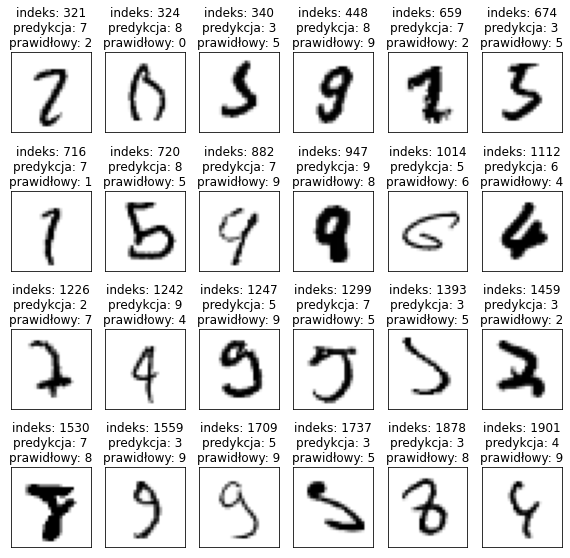

In [22]:
# Zobrazowanie pomyłek w plocie

fig,axes = plt.subplots(nrows=4,ncols=6,figsize=(8,8))
for axes, element in zip(axes.ravel(),wrong_predicted):
    index,image,predicted,right = element
    axes.imshow(image,cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(f'indeks: {index}\npredykcja: {predicted}\nprawidłowy: {right}')
plt.tight_layout()

# GUI

In [102]:
# GUI jako predykcja pisanej ręcznie liczby
 
import tensorflow as tf
from keras.models import load_model
import cv2
import numpy as np

classes=[0,1,2,3,4,5,6,7,8,9]

model=tf.keras.models.load_model('mnist_cnn.h5')

def testing():
    img=cv2.imread('image.png',0)
    img=cv2.bitwise_not(img)
##    cv2.imshow('img',img)
    img=cv2.resize(img,(28,28))
    img=img.reshape(1,28,28,1)
    img=img.astype('float32')
    img=img/255.0

    model=tf.keras.models.load_model('mnist_cnn.h5')
    pred = model.predict(img)
    return pred


from PIL import ImageTk, Image, ImageDraw
import PIL
import tkinter as tk
from tkinter import *

classes=[0,1,2,3,4,5,6,7,8,9]
width = 500
height = 500
center = height//2
white = (255, 255, 255)
green = (0,128,0)

def paint(event):
    x1, y1 = (event.x - 10), (event.y - 10)
    x2, y2 = (event.x + 10), (event.y + 10)
    cv.create_oval(x1, y1, x2, y2, fill="black",width=5)
    draw.ellipse([x1, y1,x2,y2],fill="black",width=60)
def model():
    filename = "image.png"
    image1.save(filename)
    pred=testing()
    txt.insert(tk.INSERT,"{}\nDokładność: {}%".format(classes[np.argmax(pred[0])],round(pred[0][np.argmax(pred[0])]*100,3)))
    
def clear():
    cv.delete('all')
    draw.rectangle((0,0,500, 500), fill=(255, 255, 255, 0))
    txt.delete('1.0', END)

root = Tk()
#root.geometry('1000x500') 

root.resizable(0,0)
cv = Canvas(root, width=width, height=height, bg='white')
cv.pack()

# PIL create an empty image and draw object to draw on
# memory only, not visible
image1 = PIL.Image.new("RGB", (width, height), white)
draw = ImageDraw.Draw(image1)

txt=tk.Text(root,bd=3,exportselection=0,bg='WHITE',font='Helvetica',
            padx=10,pady=10,height=5,width=20)

cv.pack(expand=YES, fill=BOTH)
cv.bind("<B1-Motion>", paint)

##button=Button(text="save",command=save)
btnModel=Button(text="Rozpoznaj",command=model)
btnClear=Button(text="Wyczyść",command=clear)
##button.pack()
btnModel.pack()
btnClear.pack()
txt.pack()
root.title('Digit recognizer')
root.mainloop()

# Recognition to run through here/console (without arguments)

In [60]:
import numpy as np
import cv2
import imutils
import argparse
import tensorflow as tf
from keras.models import load_model
import cv2
import numpy as np

image = cv2.imread("gray.jpg")
image = imutils.resize(image,width=320)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,kernel)
_,thresh = cv2.threshold(blackhat,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
thresh = cv2.dilate(thresh,None)

(cnts,_) = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
avgCntArea = np.mean([cv2.contourArea(k) for k in cnts])
digits = []
boxes = []

for (i,c) in enumerate(cnts):
    if cv2.contourArea(c)<avgCntArea/10:
        continue
    mask = np.zeros(gray.shape,dtype="uint8")
    (x,y,w,h) = cv2.boundingRect(c)
    hull = cv2.convexHull(c)
    cv2.drawContours(mask,[hull],-1,255,-1)
    mask = cv2.bitwise_and(thresh,thresh,mask=mask)
    digit = mask[y-8:y+h+8,x-8:x+w+8]
    digit = cv2.resize(digit,(28,28))
    boxes.append((x,y,w,h))
    digits.append(digit)



digits = np.array(digits)
model = load_model('mnist_cnn.h5')
labels = model.predict_classes(digits.reshape((10,28,28,1)))

pesel_str = ''

cv2.imshow("Original",image)

for (x,y,w,h),label in sorted(zip(boxes,labels)):
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),1)
    cv2.putText(image,str(label),(x+2,y-5),cv2.FONT_HERSHEY_SIMPLEX,1.0,(0,255,0),2)
    cv2.imshow("Recognized",image)
    cv2.waitKey(1)
    pesel_str += str(label)

print(f'Twój numer PESEL to: {pesel_str}')
cv2.waitKey(0)
cv2.destroyAllWindows()

Twój numer PESEL to: 9000292703


# Recognition with arguments -i image, -m model to run through console 

In [55]:
import numpy as np
import cv2
import imutils
import argparse
from keras.models import load_model

#parse arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i","--image",required=True,help="Path to image to recognize")
ap.add_argument("-m","--model",required=True,help="Path to saved classifier")
args = vars(ap.parse_args())

#read,resize and convert to grayscale
image = cv2.imread(args["image"])
image = imutils.resize(image,width=320)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

#Rectangular kernel with size 5x5
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))

#apply blackhat and otsu thresholding
blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,kernel)
_,thresh = cv2.threshold(blackhat,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
thresh = cv2.dilate(thresh,None)        #dilate thresholded image for better segmentation

#find external contours
(cnts,_) = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
avgCntArea = np.mean([cv2.contourArea(k) for k in cnts])      #contourArea for digit approximation

digits = []
boxes = []


for i,c in enumerate(cnts):
    if cv2.contourArea(c)<avgCntArea/10:
        continue
    mask = np.zeros(gray.shape,dtype="uint8")   #empty mask for each iteration

    (x,y,w,h) = cv2.boundingRect(c)
    hull = cv2.convexHull(c)
    cv2.drawContours(mask,[hull],-1,255,-1)     #draw hull on mask
    mask = cv2.bitwise_and(thresh,thresh,mask=mask) #segment digit from thresh

    digit = mask[y-8:y+h+8,x-8:x+w+8]       #just for better approximation
    digit = cv2.resize(digit,(28,28))
    boxes.append((x,y,w,h))
    digits.append(digit)

digits = np.array(digits)
model = load_model(args["model"])
#digits = digits.reshape(-1,784)    #for Multi-Layer-Perceptron
digits = digits.reshape(digits.shape[0],28,28,1)    #for Convolution Neural Networks
labels = model.predict_classes(digits)

cv2.imshow("Original",image)

#draw bounding boxes and print digits on them
for (x,y,w,h),label in sorted(zip(boxes,labels)):
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),1)
    cv2.putText(image,str(label),(x+2,y-5),cv2.FONT_HERSHEY_SIMPLEX,1.0,(0,255,0),2)
    cv2.imshow("Recognized",image)
    cv2.waitKey(1)
cv2.waitKey(0)
cv2.destroyAllWindows()

usage: ipykernel_launcher.py [-h] -i IMAGE -m MODEL
ipykernel_launcher.py: error: the following arguments are required: -i/--image, -m/--model


SystemExit: 2

# Custom image tests with CNN model

In [86]:
# Najważniejsza zasada: zależnie od tego jakie zdjęcie wybieramy do sprawdzenia, dużą różnicę robi jak grube są linie na zdjęciu.
# Na przykład liczba zapisana grubym markerem jak w image2.jpg a zapisana cienkim długopisem jak w image4.jpg wymaga zmiany wielkości jądra
# Na ten moment nie wymyśliłem czegoś co by mogło optymalizować rozmiwar jądra zależnie od zdjęcia
# Przy liczbach pisanych pisakiem wielkość jądra musi być czasami nawet 21x21 a przy długopisach +- 3-7x3-7 aby dobrze wyszukać liczby na zdjęciu

import numpy as np
import cv2
import imutils
import argparse
import tensorflow as tf
from keras.models import load_model
import cv2
import numpy as np

image = cv2.imread("test.png")
image = imutils.resize(image,width=320)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))        # Wielkość jądra do optymalizacji względem zdjęcia
blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,kernel)
_,thresh = cv2.threshold(blackhat,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
thresh = cv2.dilate(thresh,None)

(cnts,_) = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
avgCntArea = np.mean([cv2.contourArea(k) for k in cnts])
digits = []
boxes = []

for (i,c) in enumerate(cnts):
    if cv2.contourArea(c)<avgCntArea/10:
        continue
    mask = np.zeros(gray.shape,dtype="uint8")
    (x,y,w,h) = cv2.boundingRect(c)
    hull = cv2.convexHull(c)
    cv2.drawContours(mask,[hull],-1,255,-1)
    mask = cv2.bitwise_and(thresh,thresh,mask=mask)
    digit = mask[y-8:y+h+8,x-8:x+w+8]
    try:
        digit = cv2.resize(digit,(28,28))
        boxes.append((x,y,w,h))
        digits.append(digit)
    except:
        pass



digits = np.array(digits)
model = load_model('mnist_cnn.h5')
labels = model.predict_classes(digits.reshape((len(digits),28,28,1)))

pesel_str = ''

cv2.imshow("Original",image)

for (x,y,w,h),label in sorted(zip(boxes,labels)):
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),1)
    cv2.putText(image,str(label),(x+15,y+10),cv2.FONT_HERSHEY_SIMPLEX,0.70,(255,0,0),2)
    cv2.imshow("Recognized",image)
    cv2.waitKey(1)
    pesel_str += str(label)

print(f'Twój numer PESEL to: {pesel_str}')
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Python3.8\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
Twój numer PESEL to: 46235855632748321645321254321654327654326314383652239


# GUI PESEL

In [122]:
# GUI jako predykcja pisanej ręcznie liczby
 
import tensorflow as tf
from keras.models import load_model
import cv2
import numpy as np

classes=[0,1,2,3,4,5,6,7,8,9]

model=tf.keras.models.load_model('mnist_cnn.h5')

def testing():
    image = cv2.imread("image.png")
    image = imutils.resize(image,width=320)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))        # Wielkość jądra do optymalizacji względem zdjęcia
    blackhat = cv2.morphologyEx(gray,cv2.MORPH_BLACKHAT,kernel)
    _,thresh = cv2.threshold(blackhat,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    thresh = cv2.dilate(thresh,None)

    (cnts,_) = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    avgCntArea = np.mean([cv2.contourArea(k) for k in cnts])
    digits = []
    boxes = []

    for (i,c) in enumerate(cnts):
        if cv2.contourArea(c)<avgCntArea/10:
            continue
        mask = np.zeros(gray.shape,dtype="uint8")
        (x,y,w,h) = cv2.boundingRect(c)
        hull = cv2.convexHull(c)
        cv2.drawContours(mask,[hull],-1,255,-1)
        mask = cv2.bitwise_and(thresh,thresh,mask=mask)
        digit = mask[y-8:y+h+8,x-8:x+w+8]
        try:
            digit = cv2.resize(digit,(28,28))
            boxes.append((x,y,w,h))
            digits.append(digit)
        except:
            pass



    digits = np.array(digits)
    model = load_model('mnist_cnn.h5')
    labels = model.predict_classes(digits.reshape((len(digits),28,28,1)))

    pesel_str = ''


    for (x,y,w,h),label in sorted(zip(boxes,labels)):
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),1)
        cv2.putText(image,str(label),(x+15,y+10),cv2.FONT_HERSHEY_SIMPLEX,0.70,(255,0,0),2)
        cv2.waitKey(1)
        pesel_str += str(label)


    return pesel_str


from PIL import ImageTk, Image, ImageDraw
import PIL
import tkinter as tk
from tkinter import *

classes=[0,1,2,3,4,5,6,7,8,9]
width = 1800
height = 500
center = height//2
white = (255, 255, 255)
green = (0,128,0)

def paint(event):
    x1, y1 = (event.x - 3), (event.y - 3)
    x2, y2 = (event.x + 3), (event.y + 3)
    cv.create_oval(x1, y1, x2, y2, fill="black",width=1)
    draw.ellipse([x1, y1,x2,y2],fill="black",width=30)
def model():
    filename = "image.png"
    image1.save(filename)
    pred=testing()
    txt.insert(tk.INSERT,f"PESEL: {pred}")
    
def clear():
    cv.delete('all')
    draw.rectangle((0,0,2500, 2500), fill=(255, 255, 255, 0))
    txt.delete('1.0', END)

root = Tk()
#root.geometry('1000x500') 

root.resizable(0,0)
cv = Canvas(root, width=width, height=height, bg='white')
cv.pack()

# PIL create an empty image and draw object to draw on
# memory only, not visible
image1 = PIL.Image.new("RGB", (width, height), white)
draw = ImageDraw.Draw(image1)

txt=tk.Text(root,bd=3,exportselection=0,bg='WHITE',font='Helvetica',
            padx=10,pady=10,height=5,width=20)

cv.pack(expand=YES, fill=BOTH)
cv.bind("<B1-Motion>", paint)

##button=Button(text="save",command=save)
btnModel=Button(text="Rozpoznaj",command=model)
btnClear=Button(text="Wyczyść",command=clear)
##button.pack()
btnModel.pack()
btnClear.pack()
txt.pack()

root.title('Digit recognizer')
root.mainloop()